### How does Font-Clos's model compare with mine?

Francesc Font-Clos in a [2018 paper](https://arxiv.org/pdf/1412.4577.pdf) puts the _scaled_ type-token growth curve at this expression:

$$
y_F(x) = 1 - \frac{Li_{\gamma}(1-x)}{\zeta(\gamma)}
$$

Taking liberties with interpretation, we can actually replace the $(x,y) = (l/L, v/V)$ from his paper with $(x,y) = (m/M_z, E(m)/N_z)$ for trainable parameters $(M_z, N_z)$ and fixing $\gamma = 2$ for a fit exactly as accurate as my logarithmic model:

$$
y_D(x) = \frac{x\ln(x)}{x-1}
$$

And yet, _these two formulas are not analytically equivalent_. How is that even possible? How can two formulas, both begging input from the world of polylogarithms, possibly be both so accurate yet analytically distinct?

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 16,8
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd

# custom classes
from legomena import Corpus, LogModel, FontClosModel

### Choosing a Book

Select a book for use as our fitting corpus.

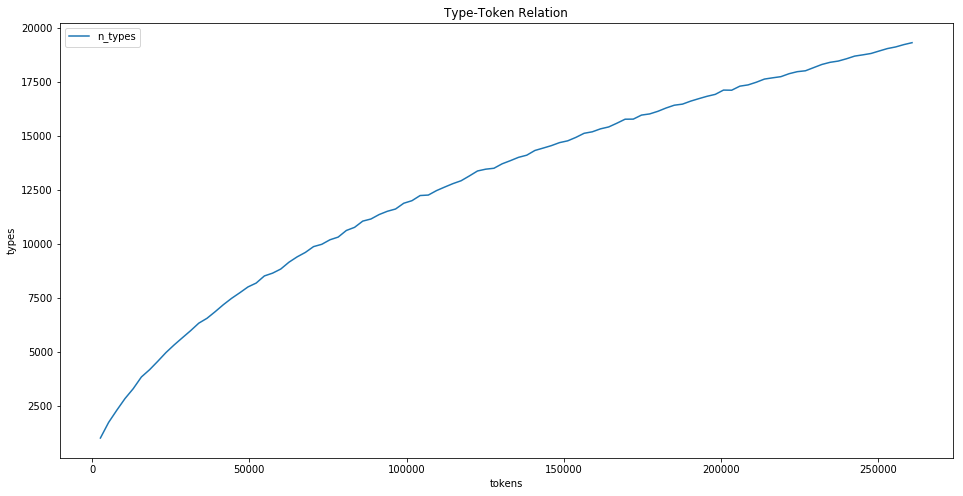

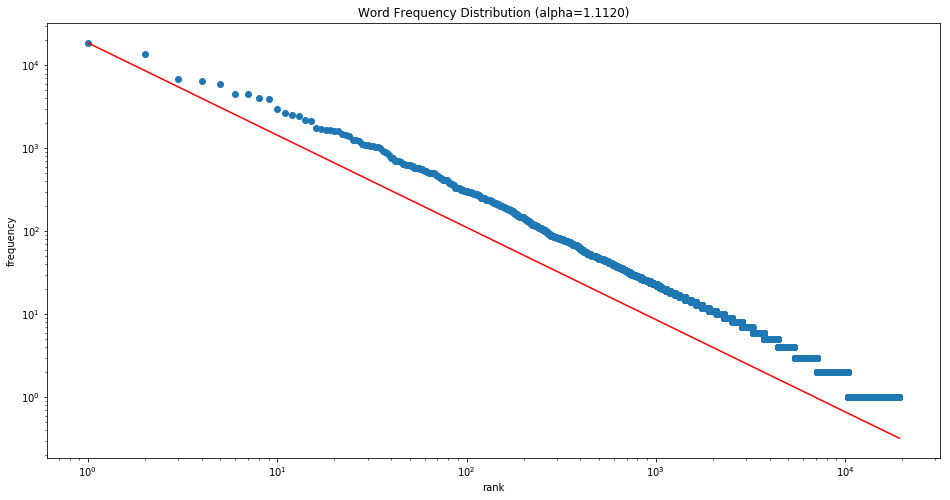

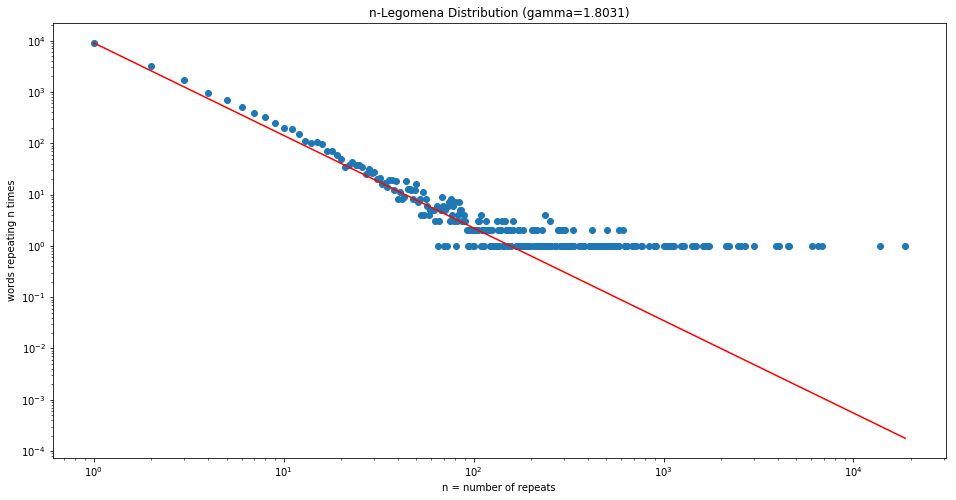

In [23]:
# moby dick
words = gutenberg.words("melville-moby_dick.txt")
corpus = Corpus(words)
TTR = corpus.TTR
m_tokens, n_types = TTR.m_tokens, TTR.n_types

# plot TTR curve
plt.plot(m_tokens, n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

# plot WFD
# xmax = 50
# i = np.arange(1, xmax)
df = corpus.fdist #.head(xmax)
rank = df.index.values
freq = df.freq.values
alpha = corpus.alpha
plt.scatter(rank, freq)
plt.loglog(rank, freq[0]/rank**alpha, color = 'r')
plt.title("Word Frequency Distribution (alpha=%0.4f)" % alpha)
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
df = corpus.kdf
rank = df.index.values
freq = df.freq.values
gamma = corpus.gamma
plt.scatter(rank, freq)
plt.loglog(rank, freq[0]/rank**gamma, color = 'r')
plt.title("n-Legomena Distribution (gamma=%0.4f)" % gamma)
plt.xlabel("n = number of repeats")
plt.ylabel("words repeating n times")
plt.show()

### Log Model

The log model finds an optimum around ~170k tokens, where $\alpha \approx 1.08$ and $\gamma \approx 1.83$. This is interesting, since a "perfect" zipf distribution would seem to imply $(\alpha, \gamma) = (1,2)$. For starters, a perfect zipf distribution is impossible, since a harmonic distribution can't exist, so $alpha$ must be at least slightly greater than one. But there's no reason why $\gamma$ can't be exactly 2. Fitting power laws is already fraught with issues, so my guess there are error bars on these exponent measurements, and they "really" might be $(1,2)$, or as close as real text can get.

Optimum = LogParams(M_z=174992, N_z=15928)
Alpha = 1.0771438486049132
Gamma = 1.8156040512431473


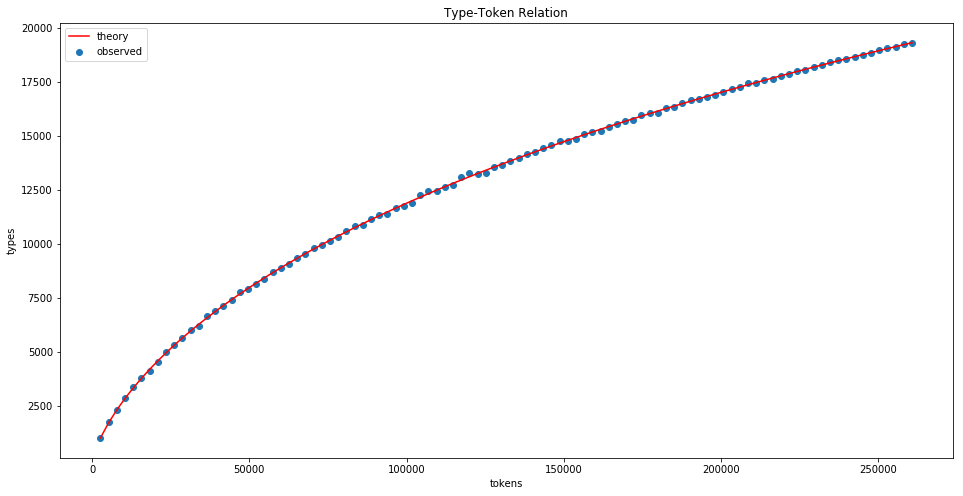

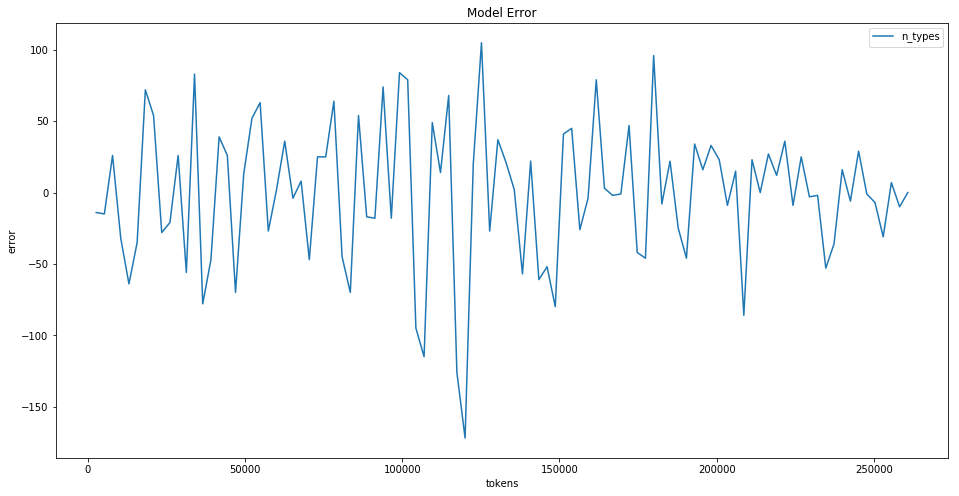

In [20]:
# fit
lmodel = LogModel().fit(m_tokens, n_types)
lpredictions = lmodel.predict(m_tokens)
print("Optimum =", lmodel.params)

# optimum sample
optimum = corpus.sample(lmodel.M_z)
print("Alpha =", optimum.alpha)
print("Gamma =", optimum.gamma)

# visualize
plt.scatter(m_tokens, n_types, label="observed")
plt.plot(m_tokens, lpredictions, color="r", label="theory")
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

# residuals
plt.plot(m_tokens, lpredictions - n_types)
plt.title("Model Error")
plt.xlabel("tokens")
plt.ylabel("error")
plt.legend()
plt.show()

### Font-Clos Model

In his paper, Font-Clos takes $x$ to be the proportion of tokens sampled from the corpus in question, and fits his model's sole parameter, $\gamma$. However, this assumes that all corpuses have exactly the same statistical properties. Certainly a 100-line poem must have a different power law distribution of words and $n$-legomena counts than, say, the bible. Therefore, I'm introducing a second-order fitting routine: Fix your $\gamma$ (presumably at $\gamma=2$), and fit a 2-parameter model to find the "optimum" number of tokens & types. That is, find the best choice of $(M,N)$, the (token,type) size of the optimum sample of the corpus matching the fixed $\gamma$.

This _does_ lead to a better fit (of course, by increasing the number of free parameters). But more importantly, it makes the residuals look more Gaussian, removing the sample-size-dependent systemic error.

Params1 = FontClosParams(M=260819, N=19317, gamma=1.7064602669355118)
Params2 = FontClosParams(M=6821, N=2117, gamma=2.5)
Alpha = 0.9380662982694145
Gamma = 2.1538525325953226


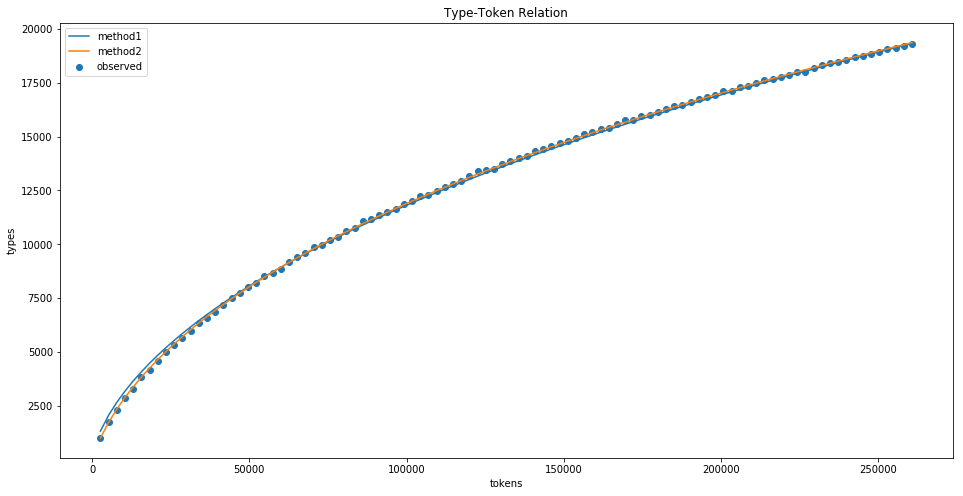

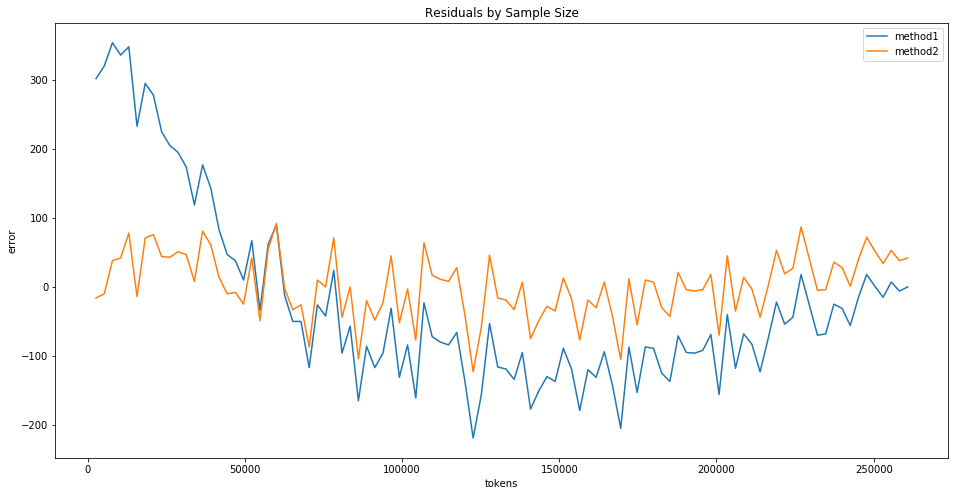

In [24]:
# fit (fix optimum, train gamma)
fmodel1 = FontClosModel().fit(m_tokens, n_types)
fpredictions1 = fmodel1.predict(m_tokens)
print("Params1 =", fmodel1.params)

# fit (fix gamma, train optimum)
fmodel2 = FontClosModel().fit_experimental(m_tokens, n_types, gamma = 2.5)
fpredictions2 = fmodel2.predict(m_tokens)
print("Params2 =", fmodel2.params)

# optimum sample
optimum = corpus.sample(fmodel2.M)
print("Alpha =", optimum.alpha)
print("Gamma =", optimum.gamma)

# predictions
plt.scatter(m_tokens, n_types, label="observed")
plt.plot(m_tokens, fpredictions1, label="method1")
plt.plot(m_tokens, fpredictions2, label="method2")
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.legend()
plt.show()

# residuals
plt.plot(m_tokens, fpredictions1 - n_types, label="method1")
plt.plot(m_tokens, fpredictions2 - n_types, label="method2")
plt.title("Residuals by Sample Size")
plt.xlabel("tokens")
plt.ylabel("error")
plt.legend()
plt.show()

## Choice of $\gamma$

Although you'd think, based on theory, that the best choice of $\gamma$ should be $\gamma=2$, this doesn't seem to be the case. Interestingly, the model fit _improves_ with increasing $\gamma$, without an apparent bottom.

In [5]:
# model metrics
def RMSE_pct(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    RMSE = np.sqrt(np.mean((y - y_hat) ** 2))
    return RMSE / y.max()

# loop over choices of gamma
data = []
for _ in range(3) # 99):  # NOTE: this takes a while
    gamma_ = np.random.uniform(1.5, 5)
    try:
        fmodel = FontClosModel().fit_experimental(m_tokens, n_types, gamma = gamma_)
        fpredictions = fmodel.predict(m_tokens)
        M_z, N_z = fmodel.M, fmodel.N
        RMSE_pct_ = RMSE_pct(n_types, fpredictions)
        data.append((gamma_, M_z, N_z, RMSE_pct_))
    except:
        continue
data = pd.DataFrame(data, columns=["gamma", "M_z", "N_z", "RMSE_pct"])
data.head()

,gamma,M_z,N_z,RMSE_pct
0,4.010424,299,162,0.005263
1,4.888321,60,41,0.009465
2,2.446726,8131,2393,0.002789
3,4.469407,129,79,0.006459
4,3.823375,423,218,0.004320


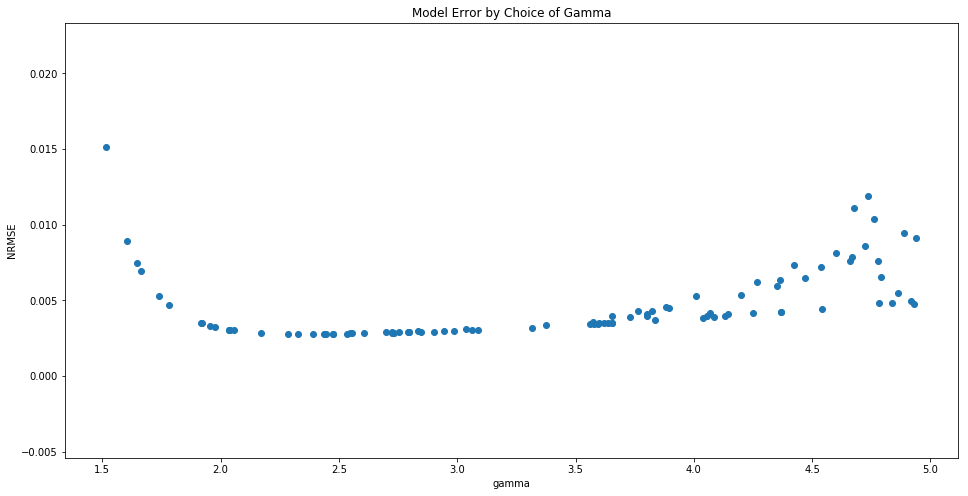

In [13]:
# ignore bad data
data = data[data.RMSE_pct < 0.02]

# RMSE ~ gamma
plt.scatter(data.gamma, data.RMSE_pct)
plt.title("Model Error by Choice of Gamma")
plt.xlabel("gamma")
plt.ylabel("NRMSE")
plt.show()

### Direct Comparison

I would have hypothesized that both models find the same optimum. That would have bolstered the case for some kind of "sweet spot" of text sample size where our models work best. Quite the opposite: My model finds Moby Dick to be nearly optimum, whereas Font-Clos finds _the lower the optimum_ (the higher the $\gamma$), the better the fit. This mystery is deepened by the fact that the two analytical formulas _do not_ appear to be alternative expressions of the same thing, regardless of the scaling. How can two analytical formulas _both_ fit empirical data with comparable and astounding (NRMSE < 0.005) accuracy, and yet be so different?

Could Font-Clos's derivation favor a "high gamma" domain, mine a lower-gamma domain, each deteriorating in effectiveness in the other's domain? If so, that would be extremely disappointing, implying that both models are wrong and there is some third model out there generalizing them.

At any rate, here's a straight comparison of both models. Even though Font-Clos's paper uses method 1, method 2 appears to be a good improvement already. Since method 2 does effectively the same thing (find the optimum), both models have the same number of free parameters and comparable performance.

In [26]:
# source data
df = pd.DataFrame({
    "m_tokens": m_tokens,
    "n_types": n_types,
    "davis": lpredictions,
    "fontclos1": fpredictions1,
    "fontclos2": fpredictions2
})

# residuals
df["davis_err"] = df.davis - df.n_types
df["fontclos1_err"] = df.fontclos1 - df.n_types
df["fontclos2_err"] = df.fontclos2 - df.n_types

# display
df.head()

,m_tokens,n_types,davis,fontclos1,fontclos2,davis_err,fontclos1_err,fontclos2_err
0,2608,1017,1014.0,1319.0,1001.0,-3.0,302.0,-16.0
1,5216,1739,1719.0,2059.0,1729.0,-20.0,320.0,-10.0
2,7824,2305,2317.0,2659.0,2343.0,12.0,354.0,38.0
3,10432,2844,2847.0,3180.0,2886.0,3.0,336.0,42.0
4,13040,3300,3330.0,3648.0,3378.0,30.0,348.0,78.0


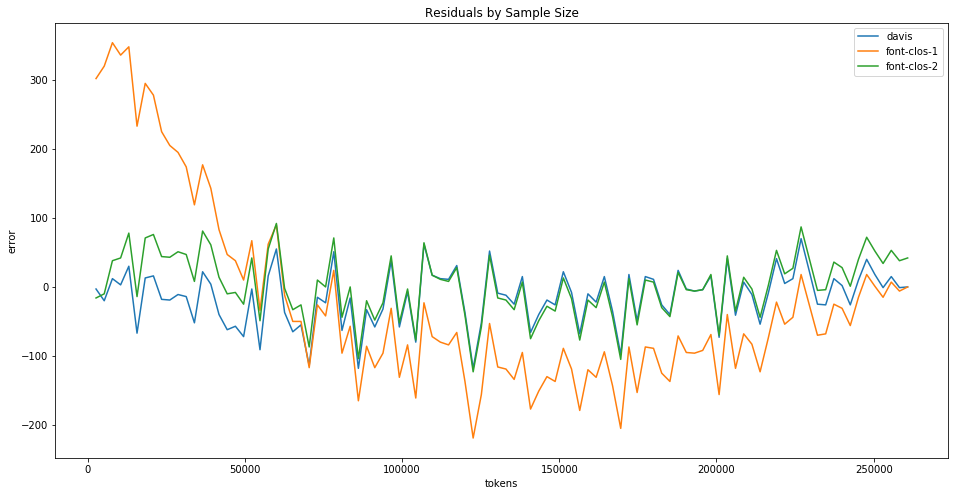

In [27]:
# residuals as a function of sample size
plt.plot(df.m_tokens, df.davis_err, label="davis")
plt.plot(df.m_tokens, df.fontclos1_err, label="font-clos-1")
plt.plot(df.m_tokens, df.fontclos2_err, label="font-clos-2")
plt.title("Residuals by Sample Size")
plt.xlabel("tokens")
plt.ylabel("error")
plt.legend()
plt.show()

In [9]:
# model metrics
def RMSE_pct(y, y_hat):
    y = np.array(y)
    y_hat = np.array(y_hat)
    RMSE = np.sqrt(np.mean((y - y_hat) ** 2))
    return RMSE / y.max()

# normalized root mean square error
NRMSE_davis = RMSE_pct(df.n_types, df.davis)
NRMSE_fontclos1 = RMSE_pct(df.n_types, df.fontclos1)
NRMSE_fontclos2 = RMSE_pct(df.n_types, df.fontclos2)

# display
print("RMSE% Font-Clos 1:", NRMSE_fontclos1)
print("RMSE% Font-Clos 2:", NRMSE_fontclos2)
print("RMSE% Davis      :", NRMSE_davis)

RMSE% Font-Clos 1: 0.006866311198880023
RMSE% Font-Clos 2: 0.00279682131537319
RMSE% Davis      : 0.0025580139847219303


## Two Optimums

Perhaps there is one last way to conceive of these two optimums. Let us ask: What is the effective $\alpha$ and $\gamma$ at these two sample sizes?

In his paper, Font-Clos asserts that $\gamma=2$ should be the correct choice. In mine, I imply the same thing by setting $k_n = 1/n/(n+1)$. Which model actually finds this "sweet spot"?

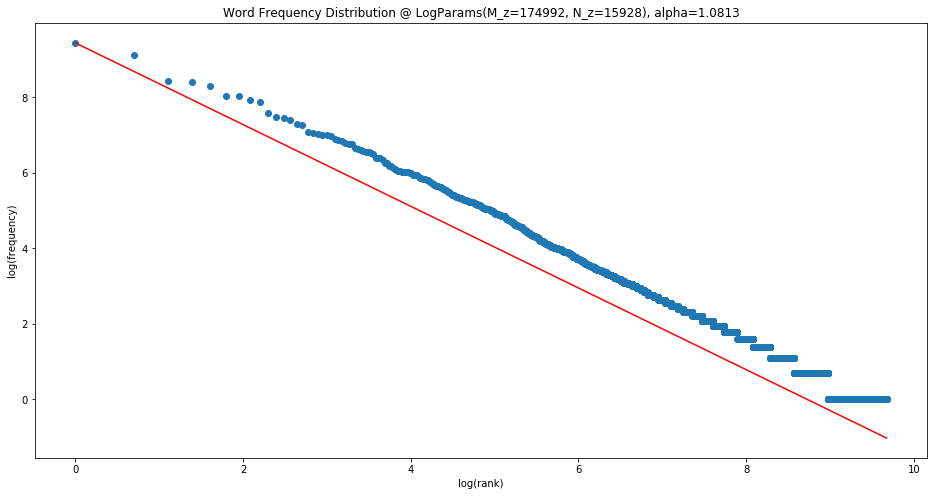

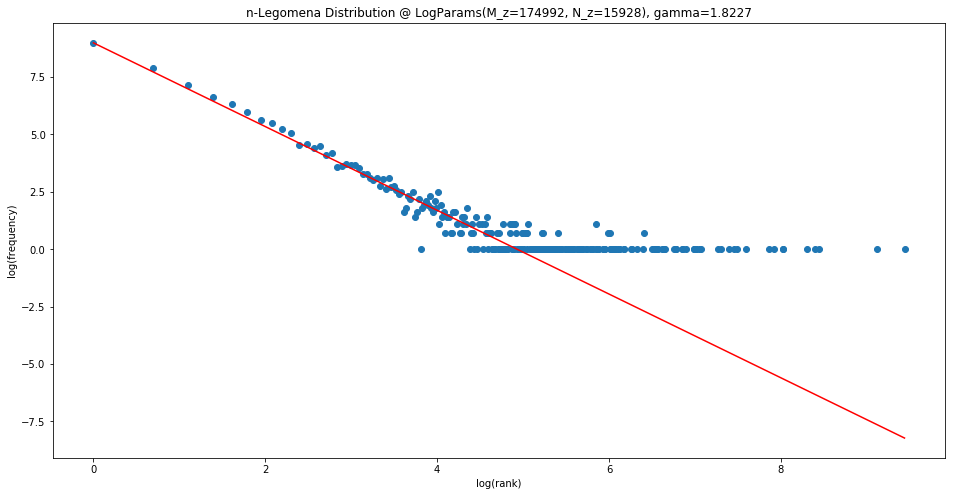

In [30]:
# what's going on at my choice of M,N?
M_z = lmodel.params.M_z
optimum = corpus.sample(M_z)

# freq = const / rank^alpha
df = optimum.fdist
df["logrank"] = np.log(df.index)
df["logfreq"] = np.log(df.freq)
xdata, ydata = df.logrank, df.logfreq
alpha = optimum.alpha

# pretty picture
plt.scatter(xdata, ydata)
plt.plot(xdata, xdata*-alpha + max(ydata), color="r")
plt.title("Word Frequency Distribution @ %s, alpha=%0.4f" % (lmodel.params, optimum.alpha))
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.show()

# counts = const / count^gamma
df = optimum.kdf
df["logrank"] = np.log(df.index)
df["logfreq"] = np.log(df.freq)
xdata, ydata = df.logrank, df.logfreq
gamma = optimum.gamma

# pretty picture
plt.scatter(xdata, ydata)
plt.plot(xdata, xdata*-gamma + max(ydata), color="r")
plt.title("n-Legomena Distribution @ %s, gamma=%0.4f" % (lmodel.params, optimum.gamma))
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.show()

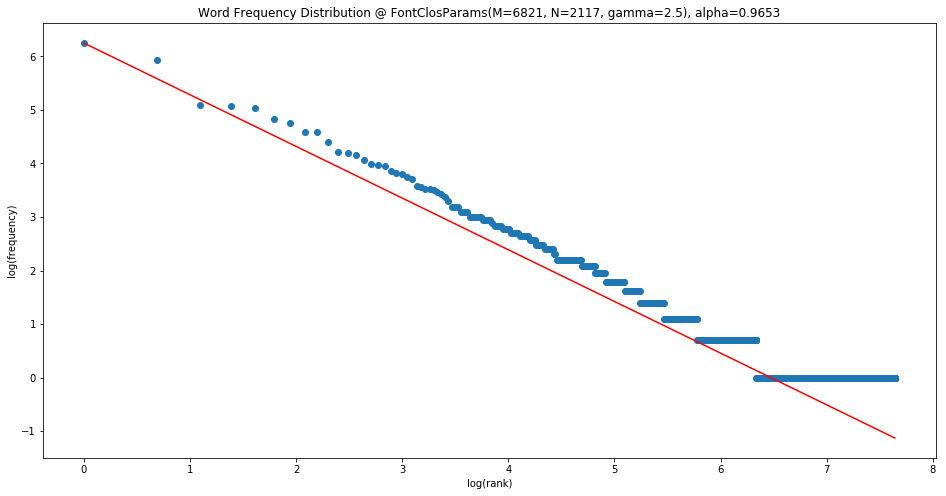

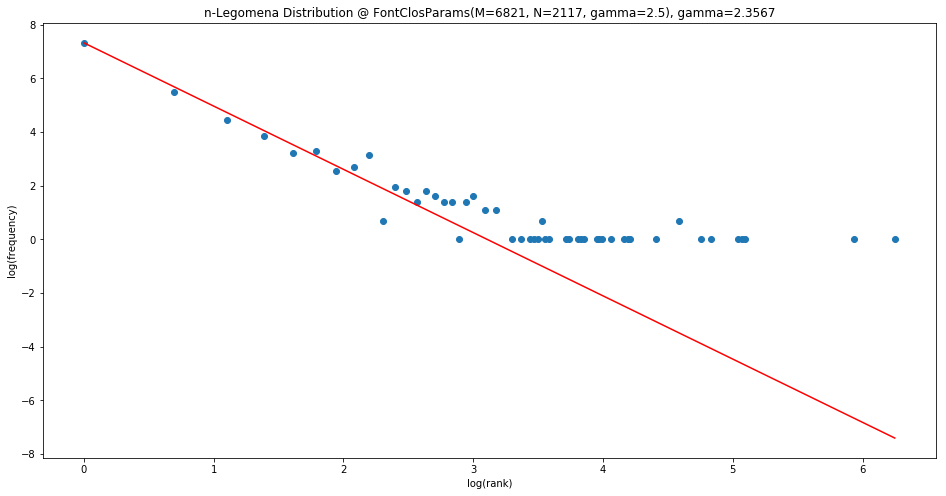

In [32]:
# what's going on at my choice of M,N?
M = fmodel2.params.M
optimum = corpus.sample(M)

# freq = const / rank^alpha
df = optimum.fdist
df["logrank"] = np.log(df.index)
df["logfreq"] = np.log(df.freq)
xdata, ydata = df.logrank, df.logfreq
alpha = optimum.alpha

# pretty picture
plt.scatter(xdata, ydata)
plt.plot(xdata, xdata*-alpha + max(ydata), color="r")
plt.title("Word Frequency Distribution @ %s, alpha=%0.4f" % (fmodel2.params, optimum.alpha))
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.show()

# counts = const / count^gamma
df = optimum.kdf
df["logrank"] = np.log(df.index)
df["logfreq"] = np.log(df.freq)
xdata, ydata = df.logrank, df.logfreq
gamma = optimum.gamma

# pretty picture
plt.scatter(xdata, ydata)
plt.plot(xdata, xdata*-gamma + max(ydata), color="r")
plt.title("n-Legomena Distribution @ %s, gamma=%0.4f" % (fmodel2.params, optimum.gamma))
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.show()

## Conclusion

In the paper, Font-Clos argues two points I take issue with:

1. That gamma is supposed to be 2, but that it can be tuned for a better fit. I've found that by fixing it _higher_ than 2 and tuning L,V instead, a better fit can be found. Theoretically, I'm adding free parameters, so it's no surprise the fit will improve. Nevertheless the fit is uncanny.
2. That his model "can lead to an overestimation ... due to finite-size effects" and can be adjusted by capping the infinite sum at a finite maximum. This is flat wrong. The finite-size adjustment may very well improve the performance of his model, but the over-estimation comes from the shape of the curve itself.